# 專題分析 - 台北市房價分析

# 1.資料匯入

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['font.family']='SimHei' #顯示中文 (for Mac)
plt.rcParams['axes.unicode_minus']=False #正常顯示負號

pd.set_option("display.max_columns",50) #設定pandas最多顯示出50個欄位資訊
df_ml = pd.read_csv('tw_house.csv', encoding='big5') #台北市
df_ml.sample(5) #隨機取其中5筆資料

,鄉鎮市區,土地移轉總面積平方公尺,建物移轉總面積平方公尺,單價每平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,車位移轉總面積平方公尺,車位總價元,屋齡,建築完成年,交易年,總價元,中山區,中正區,信義區,內湖區,北投區,南港區,士林區,大同區,大安區,文山區,松山區,萬華區
607,中山區,7.47,36.77,190373,1,1,1,0.0,0,17,89,106,700.0,1,0,0,0,0,0,0,0,0,0,0,0
498,中山區,33.50,96.46,124404,3,2,2,0.0,0,41,65,106,1200.0,1,0,0,0,0,0,0,0,0,0,0,0
266,南港區,45.18,132.55,157525,3,2,2,0.0,0,18,88,106,2088.0,0,0,0,0,0,1,0,0,0,0,0,0
110,士林區,28.67,61.77,66375,2,1,1,0.0,0,44,62,106,410.0,0,0,0,0,0,0,1,0,0,0,0,0
530,中山區,0.00,43.16,122799,1,1,1,0.0,0,18,88,106,530.0,1,0,0,0,0,0,0,0,0,0,0,0


# 2.檢查特徵相關性及線性關係

In [2]:
# 把DataFrame加上highlight背景色-凸顯要注意的feature
def highlight_highcorr(s):
    is_high = ((s >= 0.6) & (s < 1)) #Series condition setting
    return ['background-color: yellow' if v else '' for v in is_high]

## 2-1.相關性分析

In [3]:
df_ml.corr().round(3).style.apply(highlight_highcorr)

,土地移轉總面積平方公尺,建物移轉總面積平方公尺,單價每平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,車位移轉總面積平方公尺,車位總價元,屋齡,建築完成年,交易年,總價元,中山區,中正區,信義區,內湖區,北投區,南港區,士林區,大同區,大安區,文山區,松山區,萬華區
土地移轉總面積平方公尺,1,0.678,0.069,0.34,0.22,0.242,0.39,0.348,-0.068,0.068,-0.009,0.515,-0.207,-0.107,0.039,0.157,0.06,0.08,0.121,-0.081,-0.056,0.116,-0.049,-0.109
建物移轉總面積平方公尺,0.678,1,0.272,0.197,0.06,0.153,0.736,0.625,-0.411,0.411,-0.083,0.862,-0.092,-0.021,0.033,0.121,0.018,0.092,0.062,-0.03,-0.001,-0.003,-0.058,-0.132
單價每平方公尺,0.069,0.272,1,-0.081,-0.007,0.018,0.26,0.368,-0.362,0.362,-0.046,0.567,0.056,0.05,0.084,-0.05,-0.13,0.006,0.04,-0.067,0.317,-0.125,0.096,-0.203
建物現況格局-房,0.34,0.197,-0.081,1,0.675,0.755,0.032,-0.008,0.097,-0.097,-0.041,0.069,-0.084,-0.117,-0.036,0.122,-0.039,0.017,0.021,-0.01,0.016,0.073,0.024,-0.022
建物現況格局-廳,0.22,0.06,-0.007,0.675,1,0.582,-0.043,-0.08,0.046,-0.046,-0.006,-0.015,-0.046,-0.15,-0.06,0.069,-0.031,0.028,0.052,-0.019,0.048,0.071,0.052,-0.04
建物現況格局-衛,0.242,0.153,0.018,0.755,0.582,1,0.015,-0.012,-0.031,0.031,-0.084,0.067,-0.011,-0.121,0.007,0.081,-0.035,0.034,0.039,-0.037,0.042,0.049,-0.032,-0.058
車位移轉總面積平方公尺,0.39,0.736,0.26,0.032,-0.043,0.015,1,0.739,-0.464,0.464,-0.086,0.631,-0.041,-0.049,0.005,0.101,0.066,0.053,0.046,-0.023,-0.016,0.014,-0.094,-0.106
車位總價元,0.348,0.625,0.368,-0.008,-0.08,-0.012,0.739,1,-0.359,0.359,-0.053,0.683,0.017,-0.021,-0.01,0.007,0.053,0.027,0.09,-0.031,-0.013,-0.012,-0.045,-0.087
屋齡,-0.068,-0.411,-0.362,0.097,0.046,-0.031,-0.464,-0.359,1,-1,0.143,-0.403,-0.068,0.003,0.091,-0.097,-0.076,-0.12,0.113,-0.005,0.019,-0.105,0.155,0.149
建築完成年,0.068,0.411,0.362,-0.097,-0.046,0.031,0.464,0.359,-1,1,-0.143,0.403,0.068,-0.003,-0.091,0.097,0.076,0.12,-0.113,0.005,-0.019,0.105,-0.155,-0.149


## 2-2.散佈圖矩陣

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10acd59b0>,
      dtype=object)

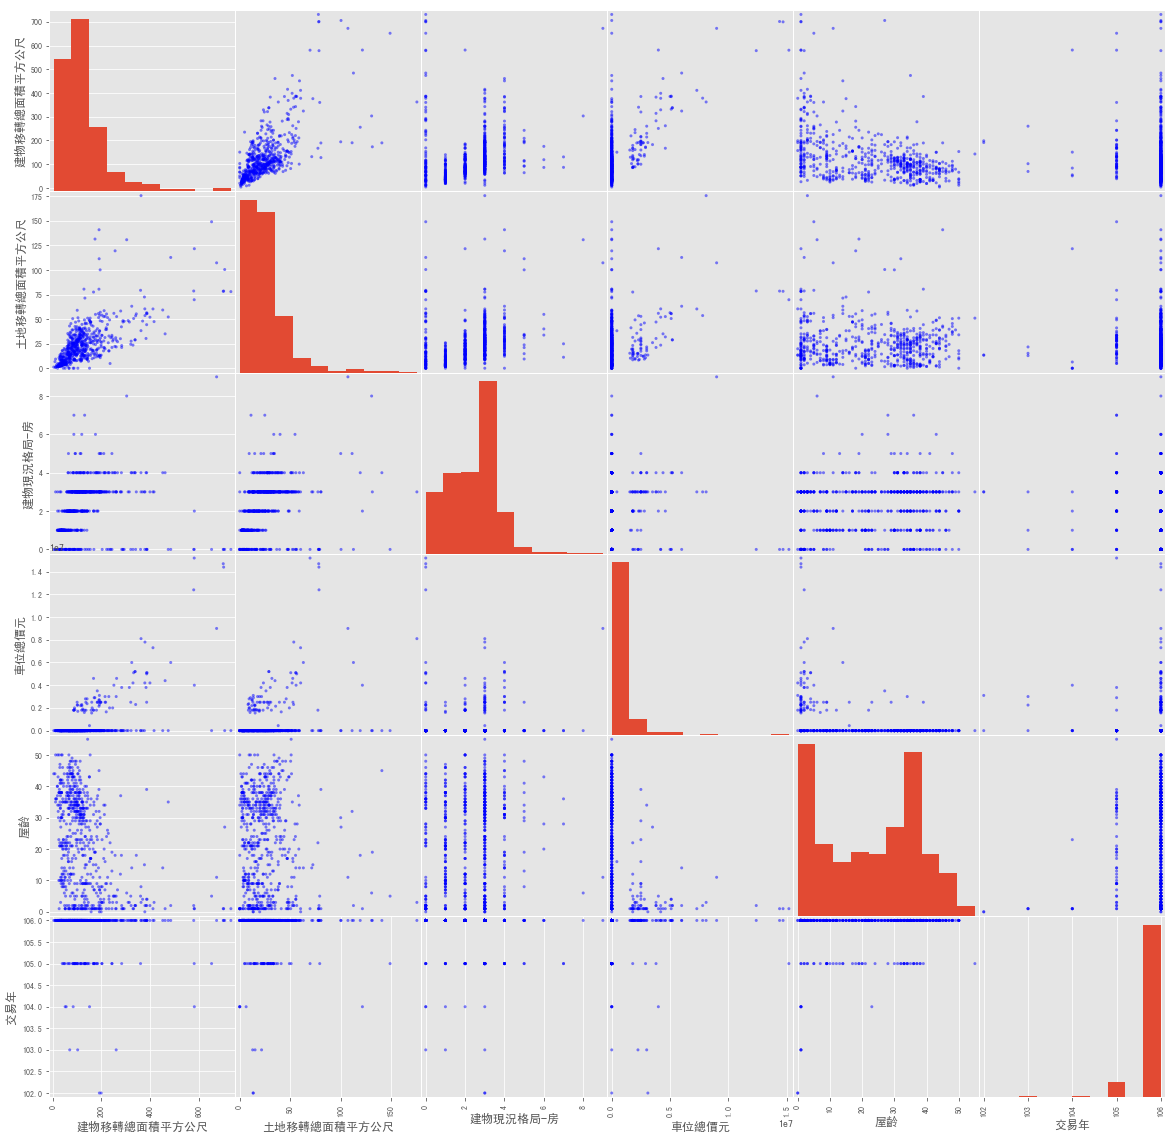

In [4]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_ml[['建物移轉總面積平方公尺','土地移轉總面積平方公尺',
                      '建物現況格局-房','車位總價元','屋齡','交易年']],figsize=(20, 20),color='b')

# 3.資料預處理 - 機器學習

## 3-1.切分訓練及測試資料 

In [5]:
from sklearn.model_selection import train_test_split

X = df_ml[['建物移轉總面積平方公尺','土地移轉總面積平方公尺','單價每平方公尺','建物現況格局-房','建物現況格局-廳','建物現況格局-衛','車位移轉總面積平方公尺','車位總價元','屋齡','建築完成年','交易年','中山區','中正區','信義區','內湖區','北投區','南港區','士林區','大同區','大安區','文山區','松山區','萬華區']]

#X = df_ml[['建物移轉總面積平方公尺']]
#X = df_ml[['車位總價元']]



y = df_ml[['總價元']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) # 30% for testing, 70% for training
X_train.head()

,建物移轉總面積平方公尺,土地移轉總面積平方公尺,單價每平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,車位移轉總面積平方公尺,車位總價元,屋齡,建築完成年,交易年,中山區,中正區,信義區,內湖區,北投區,南港區,士林區,大同區,大安區,文山區,松山區,萬華區
218,69.30,24.00,297258,0,0,2,0.0,0,34,72,106,0,0,1,0,0,0,0,0,0,0,0,0
36,103.34,29.06,127734,2,2,1,0.0,0,34,72,105,0,0,0,1,0,0,0,0,0,0,0,0
75,44.44,8.00,180018,1,1,1,0.0,0,9,97,106,0,0,0,1,0,0,0,0,0,0,0,0
586,129.52,34.81,131254,3,2,2,0.0,0,31,75,106,0,0,0,0,0,0,1,0,0,0,0,0
383,107.38,28.97,138760,3,2,2,0.0,0,34,72,106,0,0,0,1,0,0,0,0,0,0,0,0


## 3-2.標準化 

In [6]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_std = sc.transform(X)

## 3-3.產生高次方項 

In [7]:
from sklearn.preprocessing import PolynomialFeatures

quadratic = PolynomialFeatures(degree=2) #0~2次方

X_train_poly = quadratic.fit_transform(X_train_std)
X_test_poly = quadratic.fit_transform(X_test_std) 
X_poly = quadratic.fit_transform(X_std)

## 3-3.K折交叉驗證 (K-fold Cross-Validation) + 學習曲線 (Learning Curve) 

In [8]:
# Scikit-Learn 官網作圖函式
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10,6))  #調整作圖大小
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Automatically created module for IPython interactive environment


# 4.使用其他迴歸演算法進行專題分析

# 5.KNNRegressor (assign k) 

In [9]:
from sklearn.neighbors import KNeighborsRegressor

knnr = KNeighborsRegressor(n_neighbors=3,weights='uniform') # or weight='distance' or 'uniform'
knnr.fit(X_train_std, y_train)

print("MSE: %.2f" % np.mean((knnr.predict(X_test_std) - y_test) ** 2))
print("R Square:",knnr.score(X_test_std, y_test))

MSE: 2326495.82
R Square: 0.11404252807447735


## 5-1.K折交叉驗證 (K-fold Cross-Validation) + 學習曲線 (Learning Curve)

<module 'matplotlib.pyplot' from '/Users/anna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

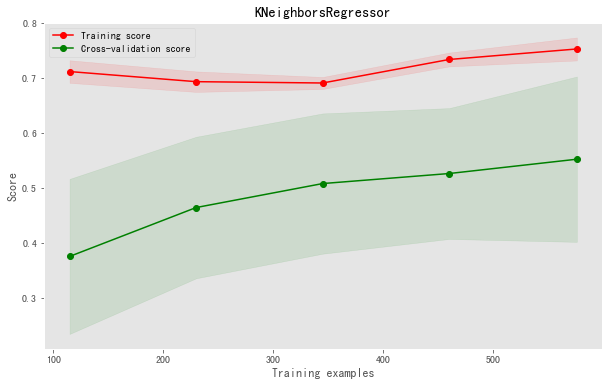

In [10]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=10, random_state=None, shuffle=True)
estimator = KNeighborsRegressor()

plot_learning_curve(estimator, "KNeighborsRegressor", X_std, y, cv=cv, train_sizes=np.linspace(0.2, 1.0, 5))

## 5-1.畫決策邊界 - 單一Feature可使用 

In [11]:
#T = np.linspace(-1, 6, 600).reshape(-1,1) #reshape成二維矩陣

#plt.figure(figsize=(10,6))
#plt.scatter(X_train_std, y_train['總價元'], c='k', label='data')
#plt.plot(T, knnr.predict(T), c='g', label='prediction')
#plt.legend()
#plt.show()

## 5-2.校調k值-uniform

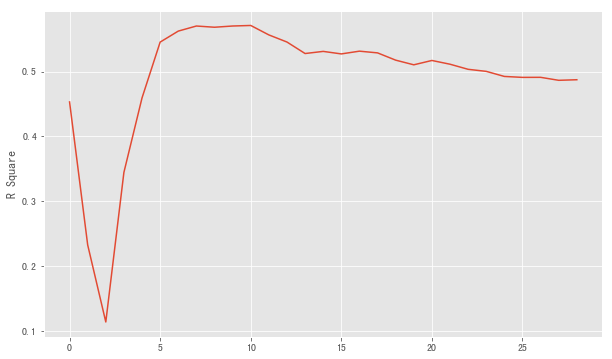

In [12]:
score_list=[]
for i in range(1,30):
    knnr = KNeighborsRegressor(n_neighbors=i)
    knnr.fit(X_train_std, y_train)
    score_list.append(knnr.score(X_test_std, y_test))
plt.figure(figsize=(10,6))
plt.ylabel('R Square')
plt.plot(score_list)

## 5-3.調整weights - distance

In [13]:
knnr = KNeighborsRegressor(n_neighbors=4,weights='distance') # or weight='distance' or 'uniform'
knnr.fit(X_train_std, y_train)

print("MSE: %.2f" % np.mean((knnr.predict(X_test_std) - y_test) ** 2))
print("R Square:",knnr.score(X_test_std, y_test))

MSE: 1573785.59
R Square: 0.400683598170695


## 5-4.K折交叉驗證 (K-fold Cross-Validation) + 學習曲線 (Learning Curve)

<module 'matplotlib.pyplot' from '/Users/anna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

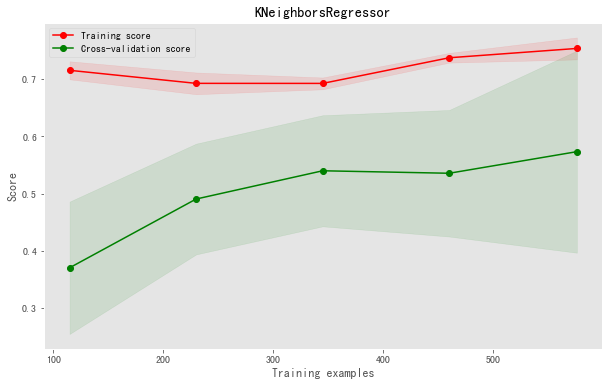

In [14]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=10, random_state=None, shuffle=True)
estimator = KNeighborsRegressor()

plot_learning_curve(estimator, "KNeighborsRegressor", X_std, y, cv=cv, train_sizes=np.linspace(0.2, 1.0, 5))

# 6.SVM Regressor

In [15]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf') #liner , poly , rbf
svr.fit(X_train_std, y_train.values.ravel()) #ravel()壓縮成一維矩陣

print("MSE: %.2f" % np.mean((svr.predict(X_test_std) - y_test.values.ravel()) ** 2))
print("R Square:",svr.score(X_test_std, y_test.values.ravel()))

MSE: 2751038.15
R Square: -0.04762827688361737


## 6-1.三種kernel比較(可tune C、degree) - 單一Feature可使用

In [16]:
#T = np.linspace(-2, 6, 600).reshape(-1,1) #reshape成二維矩陣

#svr_rbf = SVR(kernel='rbf', C=30)
#svr_lin = SVR(kernel='linear', C=30)
#svr_poly = SVR(kernel='poly', C=30, degree=2)

#y_rbf = svr_rbf.fit(X_train_std, y_train.values.ravel()).predict(T)
#y_linear = svr_lin.fit(X_train_std, y_train.values.ravel()).predict(T)
#y_poly = svr_poly.fit(X_train_std, y_train.values.ravel()).predict(T)

#plt.figure(figsize=(10,6))
#plt.scatter(X_train_std, y_train['總價元'], color='darkorange', label='data')
#plt.plot(T, y_rbf, color='navy', label='RBF model')
#plt.plot(T, y_linear, color='c', label='Linear model')
#plt.plot(T, y_poly, color='cornflowerblue', label='Polynomial model')
#plt.xlabel('data')
#plt.ylabel('target')
#plt.title('Support Vector Regression')
#plt.legend()
#plt.show()

# 7.迴歸樹

In [17]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_depth=5)
dtr.fit(X_train_std, y_train)

print("MSE: %.2f" % np.mean((dtr.predict(X_test_std) - y_test.values.ravel()) ** 2)) #.values.ravel()把矩陣轉成一維
print("R Square:",dtr.score(X_test_std, y_test))

MSE: 419882.98
R Square: 0.8401035330151685


## 7-1.K折交叉驗證 (K-fold Cross-Validation) + 學習曲線 (Learning Curve)

<module 'matplotlib.pyplot' from '/Users/anna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

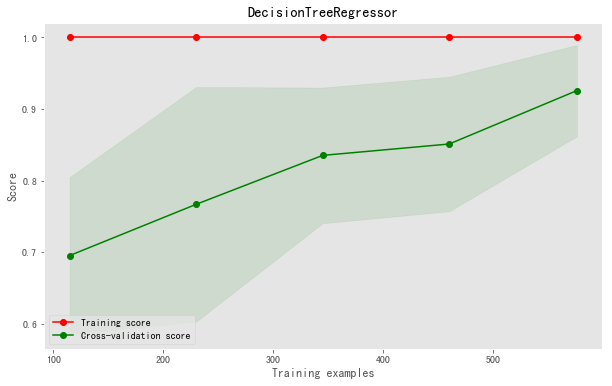

In [18]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=10, random_state=None, shuffle=True)
estimator = DecisionTreeRegressor()

plot_learning_curve(estimator, "DecisionTreeRegressor", X_std, y, cv=cv, train_sizes=np.linspace(0.2, 1.0, 5))

In [19]:
type(y_train['總價元'])

pandas.core.series.Series

## 結論

1.與前一份作業正規化的且產生高次方項的方式比較起來,顯然此份資料集比較適用於Linear Regression With L1 - 產生高次方項的演算法結果

2.此作業雖用了KNN/SVM/迴歸樹演算法,但訓練結果都不及Linear Regression With L1 - 產生高次方項來得好(99.9%)

3.總價元與建物移轉總面積很顯然有高度的正相關,但若僅使用此特徵值,訓練結果仍維持在0.6-0.7左右,須納入其他的Feature進行建模演算